## Neural Likelihood-to-Evidence Ratio Estimation

_Authors: Paul Bürkner, Lars Kühmichel, Stefan T. Radev_

## Introduction

In this notebook, we will explain how to perform likelihood-to-evidence ratio estimation using the NRE-C method of Miller et al. (2022; https://arxiv.org/abs/2210.06170). Since the likelihood-to-evidence ratio is proportional to the likelihood, we can use estimates of the former as replacement of the likelihood in self-normalizing sampling procedures, for example, in MCMC. Compared to full likelihood estimation, likelihood-to-evidence ratio estimation just requires a simple classification network for estimation, not a generative network. 

In [105]:
import bayesflow as bf
import keras

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Generative Model

We will use a simple **normal means** model as an example. Let the (unknown) mean be $\theta \in \mathbb{R}$, and assume i.i.d. observations
$$
x_i \mid \theta \sim \mathcal{N}(\theta, \sigma^2), \quad i=1,\dots,N,
$$
with known $\sigma$. We also place a prior on $\theta$, e.g.

$$
\theta \sim p(\theta) \;\; (\text{e.g. } \mathcal{N}(0,\tau^2)).
$$

Our goal is Bayesian inference for $\theta$ given data $x_{1:n}$, but we will approach it via **neural ratio estimation (NRE)**.

---

## Contrastive Likelihood-to-Evidence Ratio Estimation (NRE-C)

We use **contrastive neural ratio estimation** (NRE-C), which learns the **likelihood-to-evidence ratio**
$$
r(\theta, x) \;=\; \frac{p(x\mid \theta)}{p(x)}
$$
by training a classifier on simulated pairs $(\theta, x)$. NRE-C is a multiclass/contrastive formulation designed to avoid the bias term issues that can arise in earlier multiclass NRE variants ()

Concretely, we simulate from the model:
1. Sample $\theta \sim p(\theta)$
2. Sample $x \sim p(x\mid \theta)$

Then we train a neural network $s_\phi(\theta, x)$ so that at optimum it recovers the **log-ratio** (up to the usual equivalences of the method):
$$
s_\phi(\theta, x) \approx \log r(\theta, x).
$$

Once we have $\hat r_\phi(\theta, x) = \exp(s_\phi(\theta, x))$, we can form an approximate posterior via
$$
p(\theta\mid x) \propto p(\theta)\,\hat r_\phi(\theta, x).
$$

---

## Key property for i.i.d. data: one $x$ per simulation + later aggregation

A very convenient feature in the i.i.d. setting is that the ratio **factorizes** across observations:
$$
\hat{r}(\theta, x_{1:n})
= \frac{p(x_{1:n}\mid \theta)}{p(x_{1:n})}
= \prod_{i=1}^n \frac{p(x_i\mid \theta)}{p(x_i)}
= \prod_{i=1}^n \hat{r}(\theta, x_i).
$$
Taking logs gives the additive form:
$$
\log \hat{r}(\theta, x_{1:n}) = \sum_{i=1}^n \log \hat{r}(\theta, x_i).
$$


Thus, training can be done with *cheap* single-observation simulations, and inference for larger datasets is just a sum of per-observation network outputs.

---

## Reference (NRE-C)

Miller, B. K., Weniger, C., & Forré, P. (2022). *Contrastive Neural Ratio Estimation for Simulation-based Inference*. NeurIPS 2022, arXiv:2210.06170.

In [106]:
def prior():
    mu = 3 * np.random.standard_normal()
    return {"mu": mu}

def likelihood(mu):
    return {"x": mu + np.random.standard_normal()}

In [107]:
simulator = bf.make_simulator([prior, likelihood])

In [108]:
test_sims = simulator.sample(3)
for k, v in test_sims.items():
    print(k, v.shape)

mu (3, 1)
x (3, 1)


## Approximator

The `RatioApproximator`, which implements NRE-C, requires two key variables from the simulator: `inference_variables`, containing the model parameters (here only `mu`), and `inference_conditions`, containing the observables (here only `x`). For convenience, we adapt the simulation outputs with the default adapter.

In [109]:
adapter = bf.approximators.RatioApproximator.build_adapter(
    inference_variables=["mu"], 
    inference_conditions=["x"]
)

We initialize and fit a `RatioApproximator` in pretty much the same way as we do with other approximators in BayesFlow. One important detail is that we don't have an `inference_network` but a `classifier_network`, which can be a simple as an MLP. We could additionally specify a `summary_network` to summarize the observables before passing them to `classifier_network`, but for this simple example, we are completely fine without `summary_network`.

In [110]:
ratio_approximator = bf.approximators.RatioApproximator(
    adapter=adapter,
    classifier_network=bf.networks.MLP(widths=[64, 64]),
    standardize=None
)

In [111]:
ratio_approximator.compile(optimizer="adam")

In [112]:
history = ratio_approximator.fit(
    simulator=simulator,
    epochs=50, 
    num_batches=200, 
    batch_size=32
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4896
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1265
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0686
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0496
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0373
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0335
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0359
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0360
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0280
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0177
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0285
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0351
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0158
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0155
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

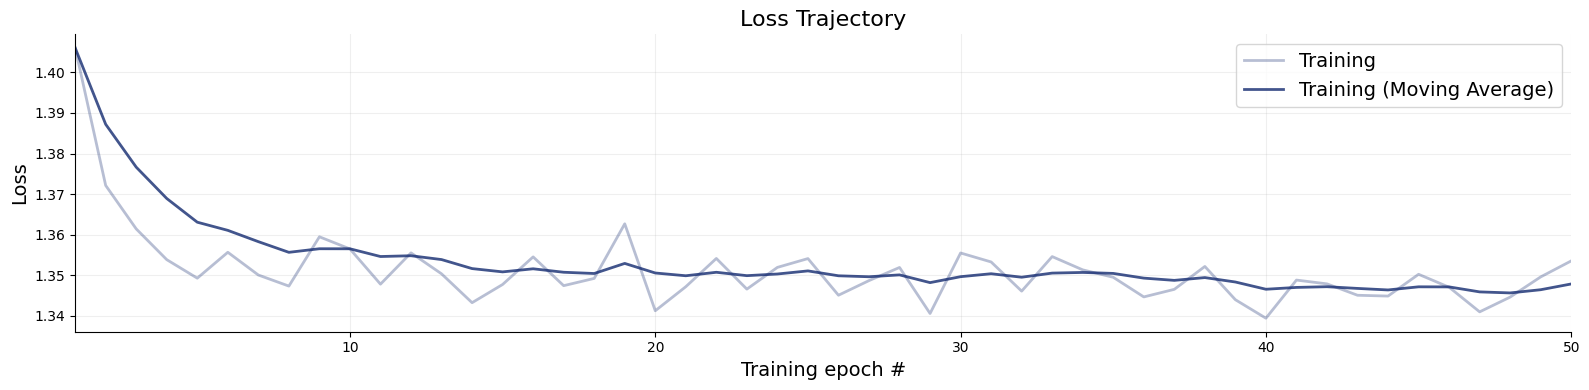

In [58]:
f = bf.diagnostics.plots.loss(history)

The amount of online simulations we used for training was probably quite a bit of an overkill and we would have gotten away with good results also with fewer simulations.

## Results

Let's perform an initial check of the approximator's results by comparing the log_ratio estimates of matching vs. non-matching (`mu`, `x`) pairs. If our ratio approximator has been learning correctly, the matching pairs should have much higher ratios than the non-matching pairs.

In [113]:
sims = simulator.sample(1000)
contrastive_sims = {
    "mu": sims["mu"][::-1],
    "x": sims["x"]
}

In [114]:
log_ratio_positive = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(sims))
log_ratio_negative = keras.ops.convert_to_numpy(ratio_approximator.log_ratio(contrastive_sims))

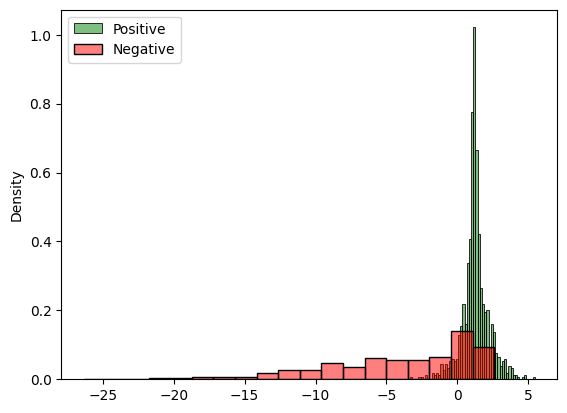

In [115]:
f, ax = plt.subplots(1, 1)
sns.histplot(log_ratio_positive, stat="density", ax=ax, label="Positive", color="green", alpha=0.5)
sns.histplot(log_ratio_negative, stat="density", ax=ax, label="Negative", color="red", alpha=0.5)
ax.legend()

Based on the above histogram, this needs seems to be the case, which is a first sanity check that what the approximator learned goes in the right direction. Let's perform some further tests.

Upon perfect learning of the likelihood-to-evidence ratio the difference of the log likelihood and the log likelihood-to-evidence ratio should be constant = log evidence. In simple cases, such as our normal means model, we have the analytic likelihood available, so we can easily verify this property. In reality, we of course usually only do likelihood-to-evidence ratio estimation if we don't actually have the likelihood available. Accordingly, bespoke check is more to verify the correctness of the general implementation rather than a practical real-world diagnostic.

In [117]:
def log_lik(x, mu):
    return norm.logpdf(x.squeeze(), loc=mu.squeeze(), scale=1)

We can check the estimated values of the log evidence for any dataset. Here, we simply choose the 7th dataset of the above-generated test simulations.

In [118]:
mu = sims["mu"]
x_obs = sims["x"]

ll = log_lik(x_obs, mu)
lr = ratio_approximator.log_ratio(sims)

<Axes: ylabel='Density'>

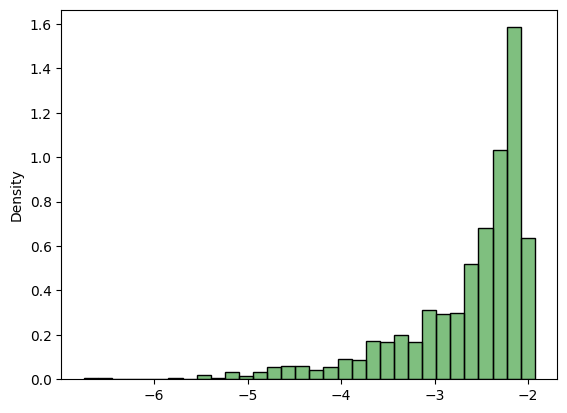

In [119]:
f, ax = plt.subplots(1, 1)
sns.histplot(ll - lr, stat="density", ax=ax, legend="Positive", color="green", alpha=0.5)

The plot indicates that, for most values of the parameter `mu`, the estimated log evidence is indeed roughly the same. However, for some parameter values, we still see quite notable deviation, indicating that the ratio approximator has not yet sufficiently converged everywhere. Likely, we would need more simulations or improved hyperparameters to gain the last percents of accuracy.

## MCMC with likelihood-to-evidence ratio approximation

We can easily plug our likelihood-to-evidence ratio approximation into PyMC to run MCMC. This just requires writing a small wrapper around our neural approximator so the input and output structure matches that expected by PyMC.

In [162]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.graph import Op, Apply

class RatioOp(Op):
    """
    Op for likelihood-to-evidence approximator: computes p(x|theta) / p(x)
    """
    def __init__(self, ratio_approximator, x_obs):
        """
        ratio_approximator: trained ratio approximator
        x_obs: observed data
        """
        self.approximator = ratio_approximator
        self.x_obs = x_obs[np.newaxis, :]
        
    def make_node(self, mu):
        mu = pt.as_tensor_variable(mu)
        return Apply(self, [mu], [pt.dscalar()])
    
    def perform(self, node, inputs, outputs):
        mu = inputs[0][np.newaxis, :]
        data = dict(x = self.x_obs, mu = mu)
        log_ratio = self.approximator.log_ratio(data)
        
        outputs[0][0] = np.asarray(log_ratio[0], dtype='float64')

In [163]:
ratio_op = RatioOp(ratio_approximator, x_obs=x_obs)

We can now incorporate the ratio approximator to a PyMC model and use basic likelihood-based samplers such as Metropolis. If we additionally specified a gradient -- which we could with the ratio approximator -- we could even run advanced MCMC algorithms such as Hamiltonian Monte Carlo. For demonstration purposes here, Metropils is sufficient. We use weakly informative priors below, to better check the effect of the ratio approximator on the resulting posterior. Since the likelihood-to-evidence ratio is independent of the prior, we can use different priors in training and during MCMC inference, something that is not immediate in directl neural posterior estimation.

In [ ]:
with pm.Model() as model:
    # uninformative prior 
    mu = pm.Normal('mu', mu=0, sigma=100, shape=1)
    # approximate ratio likelihood
    log_likelihood = ratio_op(mu)
    pm.Potential('log_likelihood', log_likelihood)
    
    trace = pm.sample(2000, step=pm.Metropolis(), chains = 1, cores = 1)

INFO:pymc.sampling.mcmc:Sequential sampling (1 chains in 1 job)
INFO:pymc.sampling.mcmc:Metropolis: [mu]


                                                                                            
  Progress   Draws   Tuning   Scaling   Accept Rate   Sampling Speed   Elapsed   Remaining  
 ────────────────────────────────────────────────────────────────────────────────────────── 
                                                                                                                  
  Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed   Elapsed   Remaining  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0       True     0.00      0.00          0.00 draws/s     0:00:00   -:--:--    
                                                                                                                  
  Progress                         Draws   Tuning   Scaling   Accept Rate   Sampling Speed   Elapsed   Remaining  
 ──────────────────────────────

INFO:pymc.sampling.mcmc:Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO:pymc.stats.convergence:Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

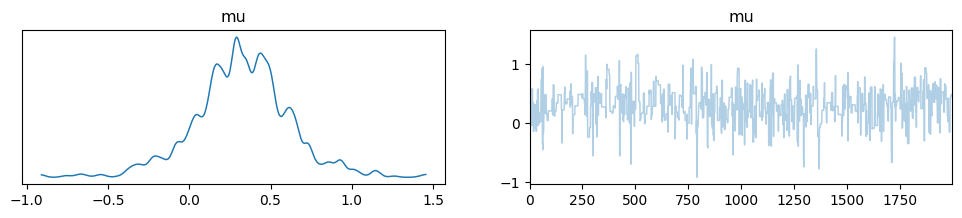

In [165]:
import arviz
arviz.plot_trace(trace)

MCMC sampling took just a few seconds and the estimation posterior looks reasonable. We further verify the posterior's accuracy by comparing it with empirical moments directly obtained from the observed data. Since we used a simple normal means model and uninformative priors, the true posterior mean of `mu` is essentially the empirical mean of the data. The same goes for the posterior standard deviation of `mu` and the empirical standard error of the observed data mean. Of course, these special relationships only old for this kind of simple model.

In [166]:
print(np.mean(trace["posterior"]["mu"]))
print(np.std(trace["posterior"]["mu"]))

<xarray.DataArray 'mu' ()> Size: 8B
array(0.32326454)
<xarray.DataArray 'mu' ()> Size: 8B
array(0.29216882)


In [167]:
print(np.mean(x_obs))
print(np.std(x_obs) / np.sqrt(x_obs.shape[0]))

0.3237774209173625
0.33390865486158006


Indeed, MCMC posterior and empirical estimates match very closely, providing further evidence that our likelihood-to-evidence ratio approximation has been successful.